In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [2]:
# !cp -r "/content/drive/MyDrive/CODE/sur_project/src/" /content
# !cp -r "/content/drive/MyDrive/CODE/sur_project/data/" /content

------ konec pripojovani souboru z disku

In [1]:
import matplotlib.pyplot as plt
import src.libs.ikrlib as il
import numpy as np
from numpy.random import randint
import scipy
from glob import glob

In [2]:
# load all files from directories
target_dev = list(il.wav16khz2mfcc('data/target_dev/').values())
target_train = list(il.wav16khz2mfcc('data/target_train/').values())
non_target_dev = list(il.wav16khz2mfcc('data/non_target_dev/').values())
non_target_train = list(il.wav16khz2mfcc('data/non_target_train/').values())

Processing file:  data/target_dev\m430_03_p01_i0_0.wav
Processing file:  data/target_dev\m430_03_p02_i0_0.wav
Processing file:  data/target_dev\m430_03_p03_i0_0.wav
Processing file:  data/target_dev\m430_03_p04_i0_0.wav
Processing file:  data/target_dev\m430_03_p05_i0_0.wav
Processing file:  data/target_dev\m430_03_r06_i0_0.wav
Processing file:  data/target_dev\m430_03_r07_i0_0.wav
Processing file:  data/target_dev\m430_03_r08_i0_0.wav
Processing file:  data/target_dev\m430_03_r09_i0_0.wav
Processing file:  data/target_dev\m430_03_r10_i0_0.wav
Processing file:  data/target_train\m430_01_p01_i0_0.wav
Processing file:  data/target_train\m430_01_p02_i0_0.wav
Processing file:  data/target_train\m430_01_p03_i0_0.wav
Processing file:  data/target_train\m430_01_p04_i0_0.wav
Processing file:  data/target_train\m430_01_p05_i0_0.wav
Processing file:  data/target_train\m430_01_r06_i0_0.wav
Processing file:  data/target_train\m430_01_r07_i0_0.wav
Processing file:  data/target_train\m430_01_r08_i0_

In [5]:
target_train = np.vstack(target_train)
non_target_train = np.vstack(non_target_train)

dim = target_train.shape[1]
dim2 = non_target_train.shape[1]
print(target_train.shape)
print(dim2)

(27252, 13)
13


PCA (mainly overtaken from SUR example project *demo_genderID.py*)
===

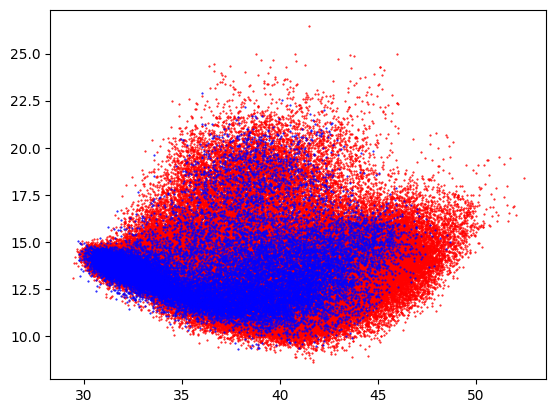

In [6]:
# PCA analysis
cov_tot = np.cov(np.vstack([target_train, non_target_train]).T, bias=True)
# division was obtained when used 5 last vectors, but still it is bad
d, e = scipy.linalg.eigh(cov_tot, subset_by_index=[dim-2, dim-1])

target_train_pca = target_train.dot(e)
non_target_train_pca = non_target_train.dot(e)
plt.plot(non_target_train_pca[:,1], non_target_train_pca[:,0], 'r.', ms=1)
plt.plot(target_train_pca[:,1], target_train_pca[:,0], 'b.', ms=1)
plt.show()

LDA (mainly overtaken from SUR example project *demo_genderID.py*)
===

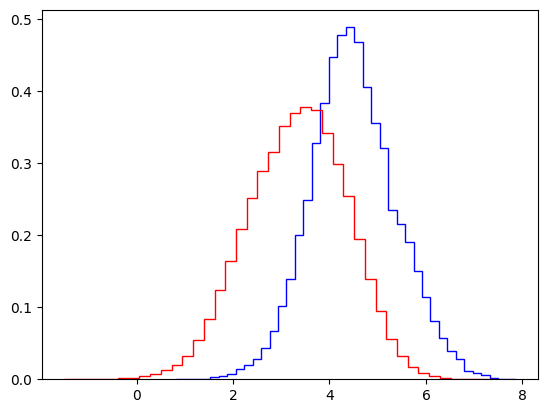

In [7]:
# LDA analysis
n_target = len(target_train)
n_non_target = len(non_target_train)
cov_wc = (n_target*np.cov(target_train.T, bias=True) + n_non_target*np.cov(non_target_train.T, bias=True)) / (n_target + n_non_target)
cov_ac = cov_tot - cov_wc
d, e = scipy.linalg.eigh(cov_ac, cov_wc, eigvals=(dim-1, dim-1))

plt.figure()
junk = plt.hist(target_train.dot(e), 40, histtype='step', color='b',density=True)
junk = plt.hist(non_target_train.dot(e), 40, histtype='step', color='r',density=True)
plt.show()

In [8]:
# do tests on LDA
# Lets define uniform a-priori probabilities of classes:
P_target = 0.5
P_non_target = 1 - P_target
test_set=non_target_dev

score=[]
mean_target, cov_target = il.train_gauss(target_train)
mean_non_target, cov_non_target = il.train_gauss(non_target_train)
for tst in test_set:
    ll_target = il.logpdf_gauss(tst, mean_target, cov_target)
    ll_non_target = il.logpdf_gauss(tst, mean_non_target, cov_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum > 0 if test_set==target_dev else score_sum < 0)
print(sum(score) / len(score))

# Run recognition with 1-dimensional LDA projected data
score=[]
mean_target, cov_target = il.train_gauss(target_train.dot(e))
mean_non_target, cov_non_target = il.train_gauss(non_target_train.dot(e))
for tst in test_set:
    ll_target = il.logpdf_gauss(tst.dot(e), mean_target, np.atleast_2d(cov_target))
    ll_non_target = il.logpdf_gauss(tst.dot(e), mean_non_target, np.atleast_2d(cov_non_target))
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum > 0 if test_set==target_dev else score_sum < 0)
print(sum(score) / len(score))


0.8833333333333333
0.85


GMM (mainly overtaken from SUR example project *demo_genderID.py*)
===

In [9]:
P_target = 0.5
P_non_target = 1 - P_target

# Decide for number of gaussian mixture components used for the target data
num_comp_target = 3
MUs_target  = target_train[randint(1, len(target_train), num_comp_target)]
COVs_target = [np.var(target_train, axis=0)] * num_comp_target
Ws_target = np.ones(num_comp_target) / num_comp_target;


# Initialize parameters of non target data
num_comp_non_target = 4
MUs_non_target  = non_target_train[randint(1, len(non_target_train), num_comp_non_target)]
COVs_non_target = [np.var(non_target_train, axis=0)] * num_comp_non_target
Ws_non_target   = np.ones(num_comp_non_target) / num_comp_non_target;

# Run 30 iterations of EM algorithm to train the two GMMs from target and non target data
target_ttl_arr = []
non_target_ttl_arr = []

for jj in range(100):
  [Ws_target, MUs_target, COVs_target, TTL_target] = il.train_gmm(target_train, Ws_target, MUs_target, COVs_target);
  [Ws_non_target, MUs_non_target, COVs_non_target, TTL_non_target] = il.train_gmm(non_target_train, Ws_non_target, MUs_non_target, COVs_non_target);
  target_ttl_arr.append(TTL_target)
  non_target_ttl_arr.append(TTL_non_target)
  print('Iteration:', jj, ' Total log-likelihood:', TTL_target, 'for target;', TTL_non_target, 'for non target')

# print(target_ttl_arr)
# plt.plot(target_ttl_arr,label='Log-likelihood of target train data')
# plt.plot(non_target_ttl_arr,label='Log-likelihood of non target train data')
# plt.legend()
# plt.show()

# perform testing
score=[]
for tst in target_dev:
    ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
    ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum)

print(score)
# print(sum(score)/len(target_dev))

score=[]
for tst in non_target_dev:
    ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
    ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
    score_sum = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
    score.append(score_sum)
print(score)

# print(sum(score)/len(non_target_dev))

Iteration: 0  Total log-likelihood: -403746.57027154026 for target; -3037684.15596922 for non target
Iteration: 1  Total log-likelihood: -344763.92902120587 for target; -2400164.2032093843 for non target
Iteration: 2  Total log-likelihood: -338641.2699783611 for target; -2274691.549648428 for non target
Iteration: 3  Total log-likelihood: -322681.28725983517 for target; -2237315.378777702 for non target
Iteration: 4  Total log-likelihood: -306853.18534927233 for target; -2220930.415648582 for non target
Iteration: 5  Total log-likelihood: -296604.4690477478 for target; -2212930.7389126066 for non target
Iteration: 6  Total log-likelihood: -290577.18947346427 for target; -2208802.3011108167 for non target
Iteration: 7  Total log-likelihood: -288901.2633734487 for target; -2206637.3660904937 for non target
Iteration: 8  Total log-likelihood: -288399.1260336874 for target; -2205484.228686768 for non target
Iteration: 9  Total log-likelihood: -288064.5645887556 for target; -2204854.7401679

## Test the GMM on your data

In [14]:
# insert path to your data here (folder with .wav files)
PATH="./../SUR_projekt2023-2024_eval/eval/"
# insert file name for the result printout
OUT_FILE="gmm-voice"

#======================================
#======================================

# parsing of the data and running test of the model
test_set = il.wav16khz2mfcc(PATH).values()

# load file names
file_names = []
for f in glob(PATH + '/*.wav'):
  file_names.append(f.removesuffix('.wav'))

Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0001.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0002.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0003.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0004.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0005.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0006.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0007.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0008.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0009.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0010.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0011.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0012.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0013.wav
Processing file:  ./../SUR_projekt2023-2024_eval/eval/eval_0014.wav
Processing file:  ./../SUR_projekt2023-2024_eval

In [15]:
# create out file
f = open(OUT_FILE, 'w')

sum_of_speaker = 0
for (tst,f_name) in zip(test_set,file_names):
  ll_target = il.logpdf_gmm(tst, Ws_target, MUs_target, COVs_target)
  ll_non_target = il.logpdf_gmm(tst, Ws_non_target, MUs_non_target, COVs_non_target)
  soft_score = (sum(ll_target) + np.log(P_target)) - (sum(ll_non_target) + np.log(P_non_target))
  hard_decission = int(soft_score > 0)
  sum_of_speaker += hard_decission
  f.write(f'{f_name.split("/")[len(f_name.split("/"))-1]} {soft_score} {hard_decission}\n')

print(sum_of_speaker/len(test_set))

0.13561847988077497


NEURAL NETWORK
===

In [4]:
# build simple neural network
import torch
import torch.nn as nn
import numpy as np
import src.libs.ikrlib as il
import scipy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from glob import glob
import src.trainmodel as tm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# load spectograms of files, also all wav files are shortened for the first 1.5s
max_length = 0
max_freq = 0

start_idx_of_signal = int(16000*1.5)
nn_target_dev = []
for f in glob('data/target_dev/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    f,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_target_dev.append(sg)

nn_target_train = []
for f in glob('data/target_train/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_target_train.append(sg)

nn_non_target_dev = []
for f in glob('data/non_target_dev/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_non_target_dev.append(sg)

nn_non_target_train = []
for f in glob('data/non_target_train/' + '/*.wav'):
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    _,t,sg = scipy.signal.spectrogram(s,fs)
    max_length = len(t) if len(t) > max_length else max_length
    max_freq = len(f) if len(f) > max_freq else max_freq
    nn_non_target_train.append(sg)


### OLD NEURAL NETWORK

In [6]:
# pad spectograms for each train data (and combine them together)
padded_spectrograms = []
for data in [nn_non_target_train,nn_target_train]:
    for spec in data:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        padded_spectrograms.append(padded_spec)

# convert padded train data to
padded_spectrograms = np.array(padded_spectrograms)

In [7]:
# compute standard deviation and mean for potentional normalization of spectrograms
spec_mean = np.mean(padded_spectrograms)
spec_std = np.std(padded_spectrograms)
padded_spectrograms = (padded_spectrograms - spec_mean) / spec_std
print(f"Spectogram mean is {spec_mean} and standard deviation is {spec_std}")

Spectogram mean is 12.048683166503906 and standard deviation is 687.1751708984375


In [8]:
# create labels (we know that non target and target data goes one by one as we loaded them two cells before)
labels_non_target = np.linspace(0,0,len(nn_non_target_train))
labels_target = np.linspace(1,1,len(nn_target_train))
labels_for_train = np.concatenate((labels_non_target,labels_target),axis=None)

In [9]:
# prepare data as input for neural network
spectrograms_tensor = torch.Tensor(padded_spectrograms).to(device)

labels_tensor = torch.LongTensor(labels_for_train).to(device)

dataset = TensorDataset(spectrograms_tensor.unsqueeze(1), labels_tensor)

In [23]:
# build the model
class CNN(nn.Module):
    def __init__(self,height,width,num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (height // 4) * (width // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)  # num_classes is the number of output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten feature maps
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

_, height, width = padded_spectrograms.shape
# Initialize the CNN model
model = CNN(height,width,2).to(device)
batch_size = 32

In [20]:
# prepare test datasets (target_dev and non_target_dev)
# pad spectograms for each test data
ps_dev = []
for data in [nn_non_target_dev,nn_target_dev]:
    for spec in data:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_dev.append(padded_spec)


ps_dev = (ps_dev - np.mean(ps_dev)) / np.std(ps_dev)

labels_non_target_test = np.linspace(0,0,len(nn_non_target_dev))
labels_target_test = np.linspace(1,1,len(nn_target_dev))
labels_for_test = np.concatenate((labels_non_target_test,labels_target_test),axis=None)

# prepare data as input for neural network
spectrograms_tensor_test = torch.Tensor(ps_dev).to(device)
labels_tensor_test = torch.LongTensor(labels_for_test).to(device)
dataset_test = TensorDataset(spectrograms_tensor_test.unsqueeze(1), labels_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [21]:
# train the model


# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([20/152,132/152])).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.005)

# create DataLoader for batch processing of train data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

hist,_,_ = tm.train(model, dataloader, dataloader_test,8,optimizer,torch.device(device),"mystring",grad_clip=0.0005,verbose=True)

New best model found! Loss: 1.3582
[Epoch: 01/10] - 7.07s | LR: 0.000100 | Train Loss: 0.6832 | Train Acc: 84.17 | Test Loss: 0.6750 | Test Acc: 84.29
New best model found! Loss: 1.3499
[Epoch: 02/10] - 6.88s | LR: 0.000100 | Train Loss: 0.6767 | Train Acc: 86.67 | Test Loss: 0.6732 | Test Acc: 85.71
New best model found! Loss: 1.3397
[Epoch: 03/10] - 6.73s | LR: 0.000100 | Train Loss: 0.6712 | Train Acc: 86.46 | Test Loss: 0.6685 | Test Acc: 85.71
New best model found! Loss: 1.3255
[Epoch: 04/10] - 6.85s | LR: 0.000100 | Train Loss: 0.6655 | Train Acc: 86.25 | Test Loss: 0.6600 | Test Acc: 85.71
New best model found! Loss: 1.3084
[Epoch: 05/10] - 6.81s | LR: 0.000100 | Train Loss: 0.6602 | Train Acc: 86.04 | Test Loss: 0.6482 | Test Acc: 85.71
New best model found! Loss: 1.3027
[Epoch: 06/10] - 6.78s | LR: 0.000100 | Train Loss: 0.6546 | Train Acc: 86.04 | Test Loss: 0.6481 | Test Acc: 85.71
New best model found! Loss: 1.2818
[Epoch: 07/10] - 7.04s | LR: 0.000100 | Train Loss: 0.6494 

In [45]:
# save currently trained model
PATH="nn_model3_0.0005.tn"
torch.save(model.state_dict(), PATH)

In [ ]:
# from src.utils import plot_graphs
# plot_graphs(hist,"a")

### Evaluate real data on model

In [16]:
# set path for output file
OUTPUT="./"
# prepare data
PATH="SUR_projekt2023-2024_eval/eval"
max_length=3517

# load spectrograms of input wavs from given folder
start_idx_of_signal = int(16000*1.5)
nn_real_data = []
file_names=[]
for f in glob(PATH + '/*.wav'):
    # add file name
    file_names.append(f.split('/')[len(f.split('/'))-1].replace('.wav',''))
    # compute the spectrogram
    fs,s = il.wavfile.read(f)
    s = s[start_idx_of_signal:]
    f,t,sg = scipy.signal.spectrogram(s,fs)
    nn_real_data.append(sg[:,:3517])
    # print(sg.shape)
    # print(file_names[0])
    # break

# pad the spectrograms
ps_real_data = []
for spec in nn_real_data:
    padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
    ps_real_data.append(padded_spec)

# convert padded spectrograms to an array
ps_real_data=np.array(ps_real_data)

# prepare data as input for neural network
spectrograms_tensor_real_data = torch.Tensor(ps_real_data).to(device)
# file_names_labels = torch.Tensor(file_names)
# dataset_real_data = TensorDataset(spectrograms_tensor_real_data.unsqueeze(1))


In [17]:
# file_names_labels = torch.Tensor(file_names)
# dataset_real_data = TensorDataset(spectrograms_tensor_real_data.unsqueeze(1))
print(len(file_names))
td_tensor = torch.Tensor(ps_real_data)
td_tensor.shape

1342


torch.Size([1342, 129, 3517])

In [22]:
f = open("nn-voice-2",'w')
# loop through the data write results to the file
f_idx = 0

# target dev spectrograms tensor
# td_tensor = torch.Tensor(ps_real_data)
sum_pred_td = 0
for t in td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0).to(device)
    output = model(input_spec)

    f.write(f'{file_names[f_idx]} {output.argmax()}\n')
    # print(f'{file_names[f_idx]}  {output.argmax()}')
    sum_pred_td += output.argmax()
    f_idx +=1

print(sum_pred_td/f_idx)
# for data in spectrograms_tensor_real_data:
#   # print(data[0].shape)
#   data = data[0].to(device)
#   output = model(data.unsqueeze(0).unsqueeze(0))
#   f.write(f'{file_names[f_idx]} {output[output.argmax()]} {output.argmax()}')
#   print(f'{file_names[f_idx]} {output[output.argmax()]} {output.argmax()}')
#   break
#   f_idx += 1

f.close()

tensor(0.0447, device='cuda:0')


### My train function

In [13]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([20/152,132/152])).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.005)

# create DataLoader for batch processing
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training
num_epochs = 10
for epoch in range(num_epochs):
    for batch_inputs, batch_labels in dataloader:
        # forward
        outputs = model(batch_inputs)
        # torch.save(model.state_dict(), PATH)
        # loss
        loss = criterion(outputs, batch_labels)
        if epoch > 0 : nn.utils.clip_grad_value_(model.parameters(), 0.0005)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.6894502639770508
Epoch 2/10, Loss: 0.6686896085739136
Epoch 3/10, Loss: 0.6750162839889526
Epoch 4/10, Loss: 0.6740677356719971
Epoch 5/10, Loss: 0.6446675658226013
Epoch 6/10, Loss: 0.6650957465171814
Epoch 7/10, Loss: 0.6581941246986389
Epoch 8/10, Loss: 0.6371967196464539
Epoch 9/10, Loss: 0.6246424317359924
Epoch 10/10, Loss: 0.6506024599075317


In [14]:
# testing
# pad spectograms for each test data
ps_target_dev = []
for spec in nn_target_dev:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_target_dev.append(padded_spec)

ps_non_target_dev = []
for spec in nn_non_target_dev:
        padded_spec = np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant')
        ps_non_target_dev.append(padded_spec)

# convert padded test data to array
ps_target_dev = np.array(ps_target_dev)
ps_non_target_dev = np.array(ps_non_target_dev)

# target dev spectrograms tensor
td_tensor = torch.Tensor(ps_target_dev)
sum_pred_td = 0
for t in td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0).to(device)
    ev = model(input_spec)
    pred_class = torch.argmax(ev).to(device)
    print(ev, pred_class)
    sum_pred_td += pred_class.int()
print(f"Success rate on target_dev: {sum_pred_td/len(td_tensor)}")

# target dev spectrograms tensor
non_td_tensor = torch.Tensor(ps_non_target_dev)
sum_pred_td = 0
for t in non_td_tensor:
    input_spec = t.unsqueeze(0).unsqueeze(0).to(device)
    ev = model(input_spec)
    pred_class = torch.argmax(ev).to(device)
    print(ev, pred_class)
    sum_pred_td += pred_class.int()
print(f"Success rate on non_target_dev: {1-sum_pred_td/len(non_td_tensor)}")

tensor([[ 19.9957, -22.0950]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(0, device='cuda:0')
tensor([[ 8.9134, 13.7012]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
tensor([[-20.3357,  40.5998]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
tensor([[-1.5929,  8.7895]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
tensor([[-9.6392, 22.6860]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
tensor([[ 10.9241, -16.0629]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(0, device='cuda:0')
tensor([[ 3.9408, 56.2969]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
tensor([[15.7805, 31.7995]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
tensor([[18.6280, -7.1468]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(0, device='cuda:0')
tensor([[ 5.1466, 22.1203]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor(1, device='cuda:0')
Succ

In [ ]:
td_tensor = torch.Tensor(ps_target_dev)
a=model(td_tensor[0].unsqueeze(0).unsqueeze(0).to(device))
torch.argmax(a)

tensor(0, device='cuda:0')